C:\Users\Kathakoli\anaconda3\envs\env_dlib\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars


0.0
0.9777710012965941
0.9898365858858176
0.6640712290692062
0.9962569072445746
0.6716834425283466
0.6175846291318062
0.6716834425283466
0.5671134631886968
0.4868004375299425
0.45473548668648295
0.4212189847851549
0.5762233860897865
0.622128803739459
0.622128803739459
0.5299582587446697
0.49697053038091205
0.622128803739459
0.6120879456424977
0.4578202520871352
0.5336993402742006
0.4578202520871352
0.5299582587446697
0.49697053038091205
0.4578202520871352
0.42402167240491084
0.5366321803857671
0.5336993402742006
0.5336993402742006
0.4943083555186576
0.49697053038091205
0.5817786228282507
0.6756146001941981
0.39471041694222025
0.49697053038091205
0.5387395544589232
0.39471041694222025
0.5817786228282507
0.46197421479395023
0.49697053038091205
0.6256926827433672
0.5366321803857671
0.42874479404166993
0.5794557093925872
0.49888314670236295
0.49888314670236295
0.5400090053285226
0.42779493044567013
0.49888314670236295
0.39614354420074255
0.46197421479395023
0.4602376749361656
0.49888314670

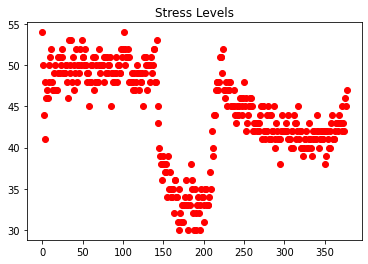

In [8]:
from scipy.spatial import distance as dist
from imutils.video import VideoStream
from imutils import face_utils
import numpy as np
import imutils
import time
import dlib
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import pygame
import os

def eye_brow_distance(leye,reye):
    global points
    distq = dist.euclidean(leye,reye)
    points.append(int(distq))
    return distq

def emotion_finder(faces,frame):
    global emotion_classifier
    EMOTIONS = ["angry" ,"disgust","scared", "happy", "sad", "surprised","neutral"]
    x,y,w,h = face_utils.rect_to_bb(faces)
    frame = frame[y:y+h,x:x+w]
    roi = cv2.resize(frame,(64,64))
    roi = roi.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi,axis=0)
    preds = emotion_classifier.predict(roi)[0]
    emotion_probability = np.max(preds)
    labelini = EMOTIONS[preds.argmax()]
    if labelini in ['scared','sad']:
        label = 'stressed'
    else:
        label = 'not stressed'
    return label,labelini
    
def normalize_values(points,disp):
    normalized_value = abs(disp - np.min(points))/abs(np.max(points) - np.min(points))
    stress_value = np.exp(-(normalized_value))
    print(stress_value)
    if stress_value>=0.55:
        return stress_value,"High Stress"
    else:
        return stress_value,"low_stress"
        
    
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
emotion_classifier = load_model("_mini_XCEPTION.102-0.66.hdf5", compile=False)
cap = cv2.VideoCapture(0)
points = []
while(True):
    _,frame = cap.read()
    frame = cv2.flip(frame,1)
    frame = imutils.resize(frame, width=500,height=500)
    
    pygame.mixer.init() #Initialize Pygame and load music
    pygame.mixer.music.load('alarm.wav')
    
    (lBegin, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]
    (rBegin, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]

    #preprocessing the image
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    
    detections = detector(gray,0)
    for detection in detections:
        emotion,emotionini = emotion_finder(detection,gray)
        cv2.putText(frame, emotion, (10,10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        shape = predictor(frame,detection)
        shape = face_utils.shape_to_np(shape)
           
        leyebrow = shape[lBegin:lEnd]
        reyebrow = shape[rBegin:rEnd]
            
        reyebrowhull = cv2.convexHull(reyebrow)
        leyebrowhull = cv2.convexHull(leyebrow)

        cv2.drawContours(frame, [reyebrowhull], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [leyebrowhull], -1, (0, 255, 0), 1)

        distq = eye_brow_distance(leyebrow[-1],reyebrow[0])
        stress_value,stress_label = normalize_values(points,distq)
        cv2.putText(frame,"stress level:{}".format(str(int(stress_value*100))),(30,40),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.putText(frame, emotionini, (10,80),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        if((stress_value*100)>55):
            cv2.putText(frame, "high_stress", (30,60),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        else:
            cv2.putText(frame, "low_stress", (30,60),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            
            

    cv2.imshow("Frame", frame)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
cv2.destroyAllWindows()
cap.release()
plt.plot(range(len(points)),points,'ro')
plt.title("Stress Levels")
plt.show()